In [1]:
import os
import pandas as pd
import numpy as np
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
from sklearn.decomposition import TruncatedSVD
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics import adjusted_rand_score
import scanpy
# sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
# sc.settings.set_figure_params(dpi=400,format='eps', transparent=True)

In [2]:
file = open('data_dictionary_orig_new.pkl', 'rb')
datMat = pickle.load(file)
cell_gene_matrix = pd.DataFrame.from_dict(datMat)
cell_gene_matrix = cell_gene_matrix.set_index('Gene')

In [3]:
genes_annot = pd.read_csv("Genes_annot.csv")
genes_annot = genes_annot[['gene_id','gene_name']]
cell_gene_matrix['gene_id'] = cell_gene_matrix.index.tolist()
genes_annot = genes_annot.drop_duplicates()
cell_gene_matrix = cell_gene_matrix.merge(genes_annot,on=["gene_id"], how = "left")
cell_gene_matrix=cell_gene_matrix.drop(columns = ['gene_id'])

C:\Users\roxan\AppData\Local\Temp\ipykernel_36960\4098922963.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cell_gene_matrix['gene_id'] = cell_gene_matrix.index.tolist()


In [4]:
tmp = cell_gene_matrix.iloc[:,:-1].astype(int)
tmp['gene_name'] = cell_gene_matrix['gene_name']
cell_gene_matrix_byName = tmp.groupby('gene_name').sum()

In [5]:
matrix = cell_gene_matrix_byName.to_numpy()
matrix = matrix.T
matrix = np.array(matrix, dtype=float)
matrix=sparse.csr_matrix(matrix) 

In [6]:
te = pd.read_csv('TE_nooverlap.csv',header = None)
te = te.rename(columns={3: 'Gene'})
te = te[['Gene']]

In [8]:
obs = pd.DataFrame()
obs['cell'] = cell_gene_matrix_byName.columns.tolist()
cell = pd.DataFrame(TE.columns.tolist())
cell.columns = ['cell']
index = obs[obs.cell.isin(cell['cell'].tolist())].index.tolist()
X = matrix[index, :]
cell = obs[obs.cell.isin(cell['cell'].tolist())]
cell.index = cell['cell']
var = pd.DataFrame(index=cell_gene_matrix_byName.index.tolist())
adata = anndata.AnnData(X, obs=cell, var=var)
adata.var["gene_name"] = cell_gene_matrix_byName.index.tolist()
adata.obs.index = adata.obs['cell']
adata.var.index = adata.var["gene_name"]

In [ ]:
adata.write('Gene.h5ad')

In [9]:
adata = sc.read_h5ad('Gene.h5ad')

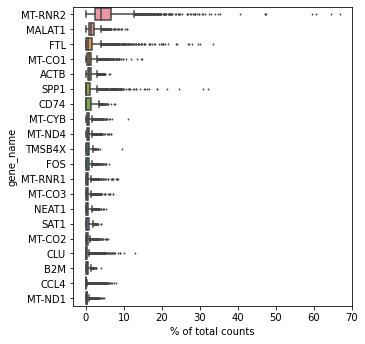

In [10]:
scanpy.pl.highest_expr_genes(adata, n_top=20)

In [11]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=10)

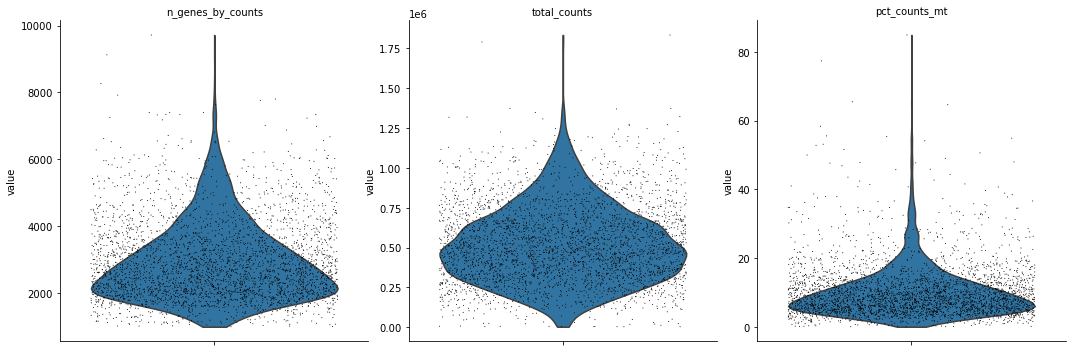

In [12]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

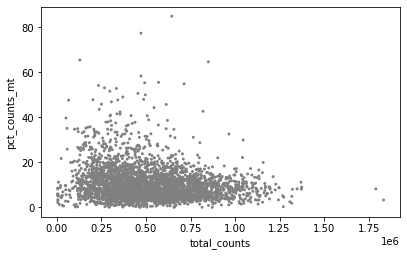

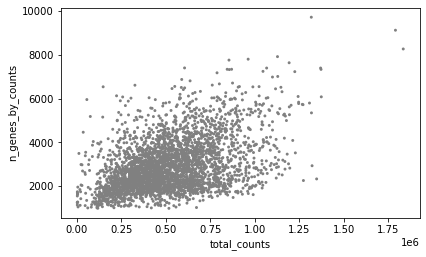

In [13]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

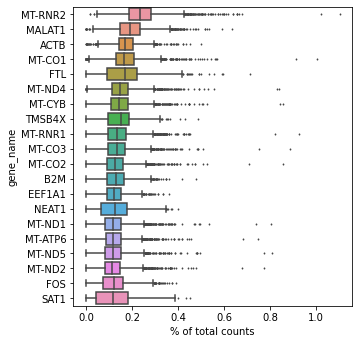

In [14]:
# normalize counts in each cell to be equal
sc.pp.normalize_total(adata, target_sum=10**4)
# Replace raw counts with their logarithm
sc.pp.log1p(adata)
sc.pl.highest_expr_genes(adata, n_top=20)

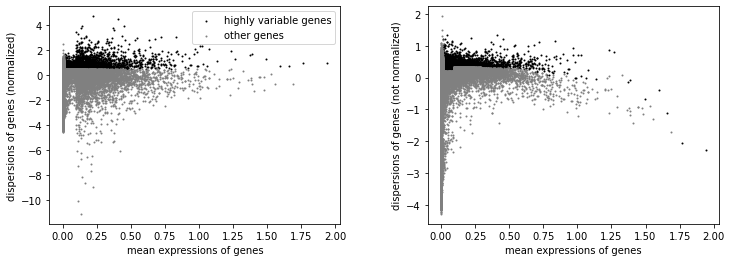

In [15]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [16]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
# sc.pl.pca(adata, color='CST3')

C:\Users\roxan\AppData\Local\Temp\ipykernel_36960\2557366456.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])


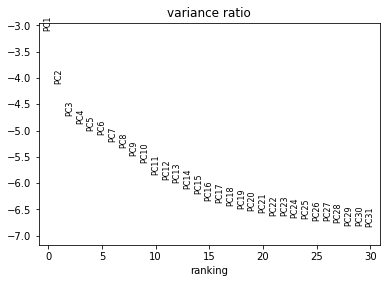

In [17]:
sc.pl.pca_variance_ratio(adata, log=True)

In [18]:
meta = pd.read_csv('SraRunTable.txt', sep = ',')
meta = meta[['Run', 'Cell_type']]
adata.obs = adata.obs.rename(columns={'cell': 'Run'})
adata.obs = adata.obs.merge(meta, how = 'left', on = ['Run'])

C:\Users\roxan\anaconda3\lib\site-packages\anndata\_core\anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [19]:
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=40)

In [20]:
import random
random.seed(21)
randomlist = random.sample(range(0, 50), 15)
ari = []
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=40)
for i in randomlist:
    sc.tl.leiden(adata, random_state = i)
    sc.tl.paga(adata)
    sc.pl.paga(adata, plot=False)
    sc.tl.umap(adata, init_pos='paga')
    predict = adata.obs.leiden.tolist()
    true = adata.obs['Cell_type'].tolist()
    ari.append(adjusted_rand_score(predict, true))

In [21]:
np.mean(ari)

0.21476007102832773

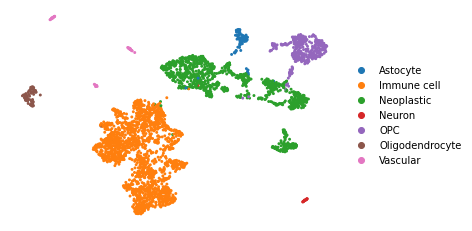

In [22]:
sc.tl.leiden(adata)
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)
sc.tl.umap(adata, init_pos='paga')
# sc.tl.paga(adata,groups='Cell_type')
sc.pl.umap(adata, color=['Cell_type'], frameon = False, title='')

In [23]:
from sklearn.metrics import adjusted_rand_score
predict = adata.obs.leiden.tolist()
true = adata.obs['Cell_type'].tolist()
adjusted_rand_score(predict, true)

0.212072649250245

In [24]:
TE = pd.read_csv('TE_MTX.csv',index_col = 0)
TE.index.name='TE'
TE=TE.fillna(0)
X = TE.T.values
obs_names = TE.columns
obs = pd.DataFrame(index=obs_names)
var_names = TE.index
var = pd.DataFrame(index=var_names)
adata_unique = anndata.AnnData(X, obs=obs, var=var, dtype='int32')
adata_unique.var["TE"] = TE.index.tolist()

In [25]:
adata = sc.read_h5ad('Gene.h5ad')

In [26]:
import scipy

In [27]:
TEvar = pd.read_csv('top_TE.csv', index_col = 0)
TE = TE[adata.obs.cell.tolist()]

In [28]:
TEvar = TEvar.index.tolist()
TEvar.extend(['L1M3a','LTR2B', 'LTR5A', 'HERVK-int'])

In [29]:
TE = TE.loc[TE.index.isin(TEvar)]

In [30]:
sparse = adata.X

newvar = pd.read_csv('top_gen3.csv', index_col = 0)
var = adata.var.reset_index(drop = True)
idx = var[var.gene_name.isin(newvar.index.tolist())].index.tolist()
sparse = sparse[:,idx]


Full = scipy.sparse.hstack((sparse, TE.T.values))
Full = Full.tocsr()

In [31]:
obs = adata.obs
obs.index.name='cell'
var_names = newvar.index.tolist() + TE.index.tolist()
var = pd.DataFrame(index=var_names)
X = Full
adata_full = anndata.AnnData(X, obs=obs, var=var, dtype='int32')
adata_full.var["Gene"] = var.index.tolist()
adata_full.var_names_make_unique()

## Combine with TE

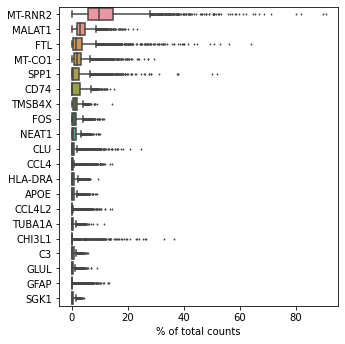

In [32]:
sc.pl.highest_expr_genes(adata_full, n_top=20)

In [33]:
sc.pp.filter_cells(adata, min_genes=1000)
sc.pp.filter_genes(adata, min_cells=10)

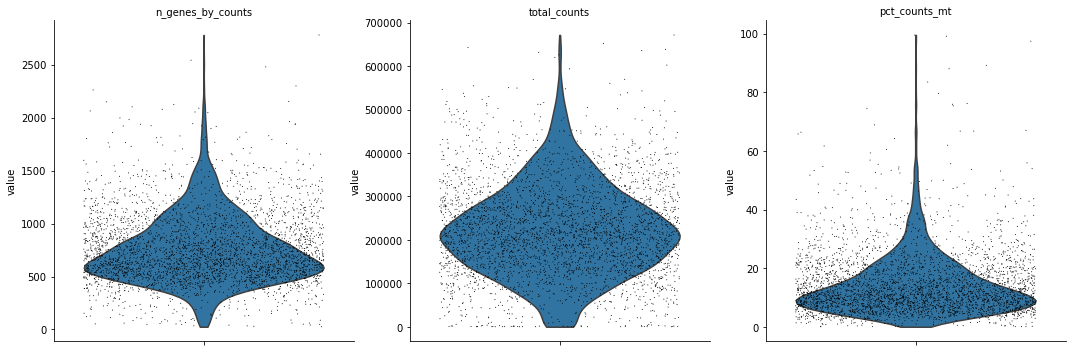

In [34]:
adata_full.var['mt'] = adata_full.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata_full, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata_full, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

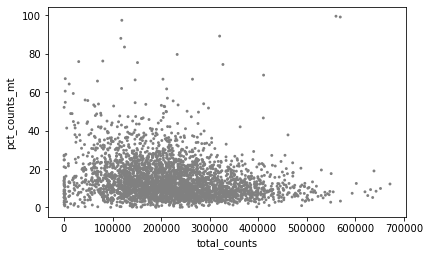

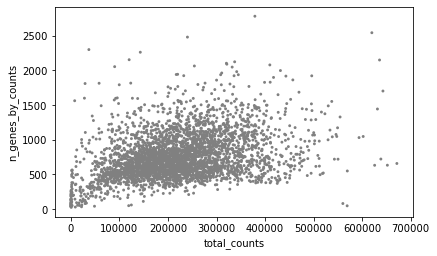

In [35]:
sc.pl.scatter(adata_full, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata_full, x='total_counts', y='n_genes_by_counts')

In [36]:
# normalize counts in each cell to be equal
sc.pp.normalize_total(adata_full, target_sum=10**4)
# Replace raw counts with their logarithm
sc.pp.log1p(adata_full)

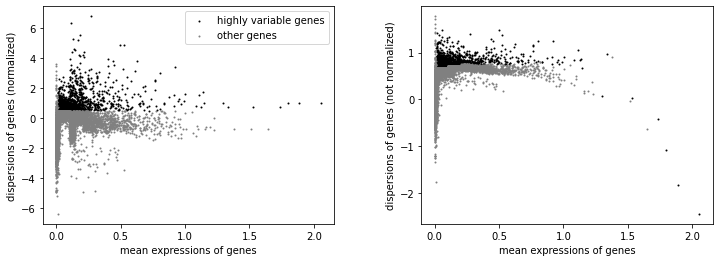

In [37]:
sc.pp.log1p(adata_full)
sc.pp.highly_variable_genes(adata_full)
sc.pl.highly_variable_genes(adata_full)

In [38]:
adata_full.raw = adata_full
adata_full = adata_full[:, adata_full.var.highly_variable]
sc.pp.regress_out(adata_full, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata_full, max_value=10)
sc.tl.pca(adata_full, svd_solver='arpack')
# sc.pl.pca(adata, color='CST3')

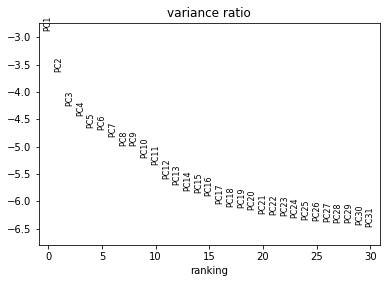

In [39]:
sc.pl.pca_variance_ratio(adata_full, log=True)

In [40]:
meta = pd.read_csv('SraRunTable.txt', sep = ',')
meta = meta[['Run', 'Cell_type']]
adata_full.obs = adata_full.obs.rename(columns={'cell': 'Run'})
adata_full.obs = adata_full.obs.merge(meta, how = 'left', on = ['Run'])

C:\Users\roxan\anaconda3\lib\site-packages\anndata\_core\anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


In [41]:
sc.pp.neighbors(adata_full, n_neighbors=20, n_pcs=40)
sc.tl.leiden(adata_full)
sc.tl.paga(adata_full)
sc.pl.paga(adata_full, plot=False)
sc.tl.umap(adata_full, init_pos='paga')

ERROR: The parameter vmax is not valid. If setting multiple vmax values,check that the length of the vmax list is equal to the number of plots. 


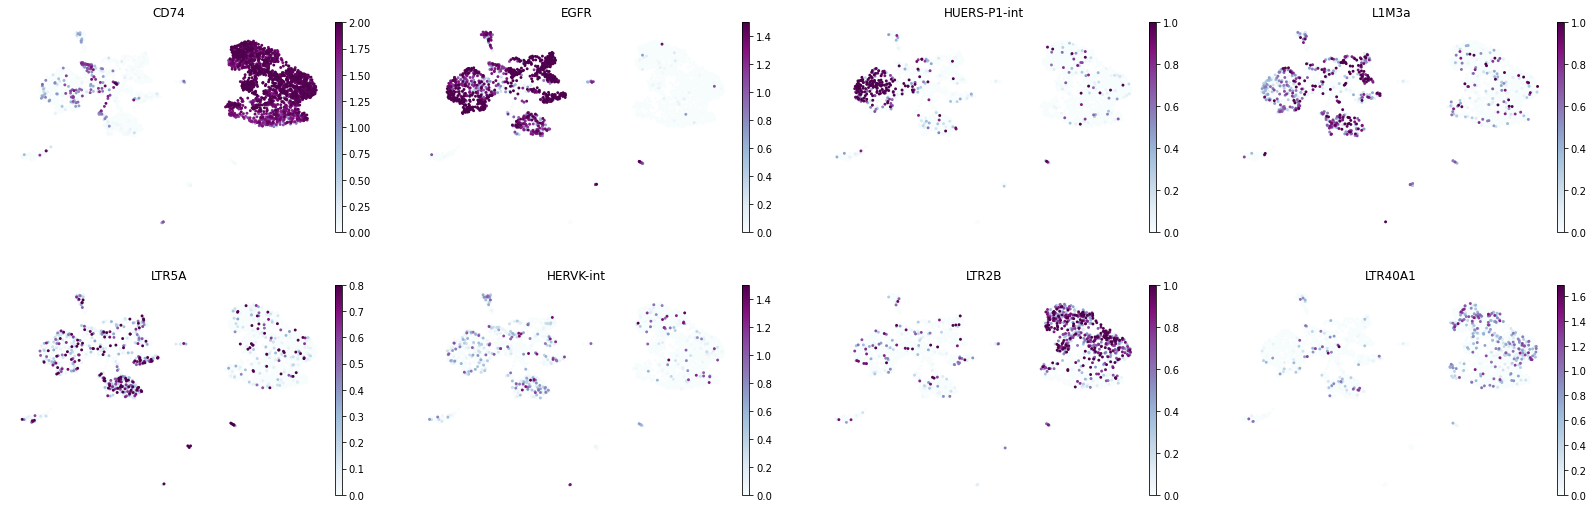

In [42]:
sc.pl.umap(adata_full, color=['CD74','EGFR','HUERS-P1-int','L1M3a', 'LTR5A', 'HERVK-int', 'LTR2B','LTR40A1'], vmax = [2, 1.5, 1, 1,0.8,1.5,1],
           frameon = False, color_map =
    'BuPu')

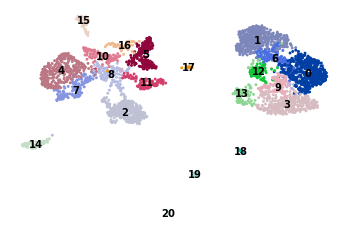

In [43]:
sc.pl.umap(adata_full, color=['leiden'],legend_loc = 'on data', legend_fontsize = 10, title = '', colorbar_loc=None,frameon = False
           )

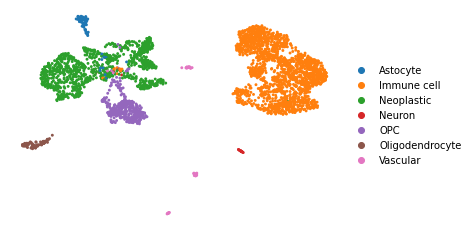

In [44]:
sc.pl.umap(adata_full, color=['Cell_type'],title = '', colorbar_loc=None,frameon = False
          )

In [45]:
import random

from sklearn.metrics import adjusted_rand_score
random.seed(21)
randomlist = random.sample(range(0, 50), 15)
ari = []
sc.pp.neighbors(adata_full, n_neighbors=20, n_pcs=40)
for i in randomlist:
    sc.tl.leiden(adata_full, random_state = i)
    sc.tl.paga(adata_full)
    sc.pl.paga(adata_full, plot=False)
    sc.tl.umap(adata_full, init_pos='paga')
    predict = adata_full.obs.leiden.tolist()
    true = adata_full.obs['Cell_type'].tolist()
    ari.append(adjusted_rand_score(predict, true))


In [46]:
np.mean(ari)

0.2482947007152754

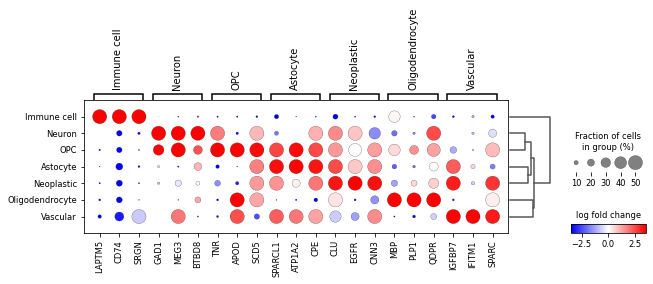

In [47]:
sc.tl.rank_genes_groups(adata_full, groupby='Cell_type', method='wilcoxon')
sc.pl.rank_genes_groups_dotplot(adata_full, n_genes=3, min_logfoldchange=1, values_to_plot='logfoldchanges', dot_max = 0.5, vmax=3.5, vmin=-3.5, cmap='bwr')

In [49]:
# var_names = {'Immune cell': ['CD74','LTR2B','LTR40A1'],
#               'Neuron': ['BTBD8', 'L1PA17', 'THE1C'],
#             'OPC': ['TNR', '(CTCTCT)n', 'L1PA3'],
#             'Astocyte': ['ATP1A2','Helitron2Na_Mam', 'LTR16B'],
#             'Neoplastic': ['EGFR','HERVK-int','LTR5A'],
#             'Oligodendrocyte': ['PLP1', 'tRNA-Gly-GGY','LTR12E'],
#             'Vascular': ['IFITM1', 'SSU-rRNA_Hsa','(AGAC)n']}
# sc.pl.rank_genes_groups_dotplot(
#     adata_full,
#     var_names=var_names,
#     values_to_plot="logfoldchanges",
#     cmap='bwr',
#     dot_max = 0.35, vmax=3, vmin=-3,
#     colorbar_title='log fold change'
# )